In [ ]:
import tweepy
from tweepy import *
import numpy as np
import pandas as pd
import csv
import re
import string
!pip install text2emotion

import nltk

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import text2emotion as te

from collections import Counter
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix, classification_report

!pip install tweet-preprocessor
import preprocessor as p

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#Getting twitter API credentials

consumer_key = "yev654S6IjEqT1llVwamETvvj"
consumer_secret = "oWhhTko4qpjrFR0X4lBcfd1cIxeSbhDRyoXdU3y697g3UvLPrg"
access_token = "349555866-5DEzm7PJvEtSVCEFkojjs2M8ucDMVhq3UZdonjHT"
access_token_secret = "l3hCINaclx0pFSoHwwrBgpHpRTOm4CnrpVvfiVS1lSPsb"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [ ]:
#Opening CSV file for storing the extracted data

csvFile = open('/content/drive/MyDrive/Mini Project/tweet_dataset', 'w')
csvWriter = csv.writer(csvFile)

In [ ]:
search_words = input("Enter Topic to Analyze ")

Enter Topic to Analyze covid


In [ ]:
#Getting the dataset based on required topic
%%time
tweets = tweepy.Cursor(api.search,q=search_words,lang="en").items(5000)
tweets_list = [[tweet.text, tweet.id_str, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count] for tweet in tweets]
df = pd.DataFrame(tweets_list,columns=['Tweet_Text', 'Tweet_Id', 'Twitter_@_Name', 'Retweets', 'Favorites'])

CPU times: user 2.62 s, sys: 152 ms, total: 2.77 s
Wall time: 27min 21s


In [ ]:
df.shape

(5000, 5)

In [ ]:
df.to_csv('/content/drive/MyDrive/Mini Project/originaldataset.csv')

In [ ]:
df=pd.read_csv(r'/content/drive/MyDrive/Mini Project/originaldataset.csv')

In [ ]:
df2=pd.read_csv(r'/content/drive/MyDrive/Mini Project/originaldataset.csv')

In [ ]:
df2.head()

,Unnamed: 0,Tweet_Text,Tweet_Id,Twitter_@_Name,Retweets,Favorites
0,0,RT @BW: Tired of California or New York? Here's where (and why) Americans are moving to during Covid https://t.co/ZcIwweYiQv,1343601835538583552,Jenny_Tang25,11,0
1,1,"@SouthTahoeNow from my opinion, more slaves with masks more cases of covid.... the numbers appear to me to be dir… https://t.co/De73yDTTDI",1343601834846351360,know357,0,0
2,2,RT @remzel__: when covid is over im throwing my mask in the air like i graduated,1343601834682961920,TappedSM,209,0
3,3,They shall all recover after a week so why call the game off when they can quarantine as a team 🤦🏽‍♂️😅.... \nThis co… https://t.co/NenGbjxe6F,1343601834603274242,clean_oak,0,0
4,4,"COVID-19 numbers are still spiking in Bexar County, where 112,218 residents have tested positive and 1,510 have di… https://t.co/YtopXiSmkX",1343601834544525312,JacksonKENS5,0,0


In [ ]:
def preprocess_tweet(row):
    text = row['Tweet_Text']
    text = p.clean(text)
    return text

df['Tweet_Text'] = df.apply(preprocess_tweet, axis=1)

In [ ]:
df.head()

,Tweet_Text,Tweet_Id,Twitter_@_Name,Retweets,Favorites
0,: Tired of California or New York? Here's where (and why) Americans are moving to during Covid,1343601835538583552,Jenny_Tang25,11,0
1,"from my opinion, more slaves with masks more cases of covid.... the numbers appear to me to be dir",1343601834846351360,know357,0,0
2,: when covid is over im throwing my mask in the air like i graduated,1343601834682961920,TappedSM,209,0
3,They shall all recover after a week so why call the game off when they can quarantine as a team .... This co,1343601834603274242,clean_oak,0,0
4,"COVID-19 numbers are still spiking in Bexar County, where residents have tested positive and have di",1343601834544525312,JacksonKENS5,0,0


In [ ]:
lemmatizer = WordNetLemmatizer()
regular_exp = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def stop(text):
    text = re.sub(regular_exp,' ', str(text).lower()).strip()
    tokens = []
    [tokens.append(lemmatizer.lemmatize(word)) for word in text.split() if not word in stopwords.words()]
    return (' ').join(tokens)

In [ ]:
df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x:stop(x))

In [ ]:
df.head()

,Tweet_Text,Tweet_Id,Twitter_@_Name,Retweets,Favorites
0,tired california new york american moving covid,1343601835538583552,Jenny_Tang25,11,0
1,opinion slave mask case covid number appear,1343601834846351360,know357,0,0
2,covid throwing mask air like graduated,1343601834682961920,TappedSM,209,0
3,shall recover week call game quarantine team co,1343601834603274242,clean_oak,0,0
4,covid 19 number still spiking bexar county resident tested positive,1343601834544525312,JacksonKENS5,0,0


In [ ]:
df.to_csv('/content/drive/MyDrive/Mini Project/lemmadataset.csv')

In [ ]:
df1=pd.read_csv(r'/content/drive/MyDrive/Mini Project//lemmadataset.csv')

In [ ]:
df1.head()

,Unnamed: 0,Tweet_Text,Tweet_Id,Twitter_@_Name,Retweets,Favorites
0,0,tired california new york american moving covid,1343601835538583552,Jenny_Tang25,11,0
1,1,opinion slave mask case covid number appear,1343601834846351360,know357,0,0
2,2,covid throwing mask air like graduated,1343601834682961920,TappedSM,209,0
3,3,shall recover week call game quarantine team co,1343601834603274242,clean_oak,0,0
4,4,covid 19 number still spiking bexar county resident tested positive,1343601834544525312,JacksonKENS5,0,0


In [ ]:
def handle_contractions(x):
    x = tokenizer.tokenize(str(x))
    return x

In [ ]:
df1['Tweet_Text'] = df1['Tweet_Text'].apply(lambda x: handle_contractions(x))

In [ ]:
df1.head()

,Unnamed: 0,Tweet_Text,Tweet_Id,Twitter_@_Name,Retweets,Favorites
0,0,"[tired, california, new, york, american, moving, covid]",1343601835538583552,Jenny_Tang25,11,0
1,1,"[opinion, slave, mask, case, covid, number, appear]",1343601834846351360,know357,0,0
2,2,"[covid, throwing, mask, air, like, graduated]",1343601834682961920,TappedSM,209,0
3,3,"[shall, recover, week, call, game, quarantine, team, co]",1343601834603274242,clean_oak,0,0
4,4,"[covid, 19, number, still, spiking, bexar, county, resident, tested, positive]",1343601834544525312,JacksonKENS5,0,0


In [ ]:
all_words = []
for r in df1['Tweet_Text']:
    all_words += r
Counter(all_words).most_common(10)
temp = pd.DataFrame(Counter(all_words).most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='icefire')

,Common_words,count
0,covid,3378
1,19,988
2,people,434
3,vaccine,372
4,new,354
5,trump,343
6,said,327
7,relief,305
8,bill,304
9,case,299


In [ ]:
#Labelling sentiments as positive, negative and neutral

sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['Tweet_Text'].apply(lambda x: sid.polarity_scores(x))
def convert(x):
    if x < 0:
        return "negative"
    elif x > 0.2:
        return "positive"
    else:
        return "neutral"
df['sentiment'] = df['sentiment'].apply(lambda x:convert(x['compound']))

In [ ]:
#Labelling the dataset for emotion

def emomax(s):
    h = te.get_emotion(s)
    Keymax = max(h, key=h.get)
    return Keymax


df['emotions'] = df['Tweet_Text'].apply(lambda x:emomax(x))
df2['emotions'] = df2['Tweet_Text'].apply(lambda x:emomax(x))

In [ ]:
df.head()

,Tweet_Text,Tweet_Id,Twitter_@_Name,Retweets,Favorites,sentiment,emotions
0,tired california new york american moving covid,1343601835538583552,Jenny_Tang25,11,0,negative,Happy
1,opinion slave mask case covid number appear,1343601834846351360,know357,0,0,neutral,Sad
2,covid throwing mask air like graduated,1343601834682961920,TappedSM,209,0,positive,Sad
3,shall recover week call game quarantine team co,1343601834603274242,clean_oak,0,0,neutral,Surprise
4,covid 19 number still spiking bexar county resident tested positive,1343601834544525312,JacksonKENS5,0,0,positive,Fear


In [ ]:
def plot_wordcloud(text, mask=None, max_words=1000, max_font_size=100, figure_size=(8.0,8.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(stop_words)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

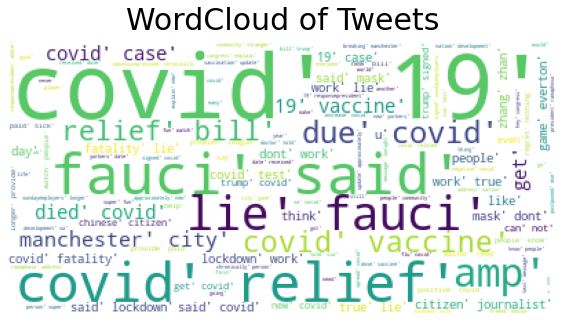

In [ ]:
plot_wordcloud(all_words,mask=None,color='white',max_font_size=100,title_size=30,title="WordCloud of Tweets")

## **Sentiment Analysis**

In [ ]:
total=df.sentiment.shape[0]
positive_count=df[df.sentiment == 'positive'].shape[0]
print("Positive percent - ",positive_count*100/total,"%")
negative_count=df[df.sentiment == 'negative'].shape[0]
print("Negative percent - ",negative_count*100/total,"%")
neutral_count=df[df.sentiment == 'neutral'].shape[0]
print("Neutral percent  - ",neutral_count*100/total,"%")

if max(positive_count,negative_count,neutral_count)==neutral_count:
  print("\033[1mNEUTRAL is maximum")
elif max(positive_count,negative_count,neutral_count)==negative_count:
  print("\033[1mNEGATIVE is maximum")
else:
  print("\033[1mPOSITIVE is maximum")

Positive percent -  30.42 %
Negative percent -  41.08 %
Neutral percent  -  28.5 %
NEGATIVE is maximum


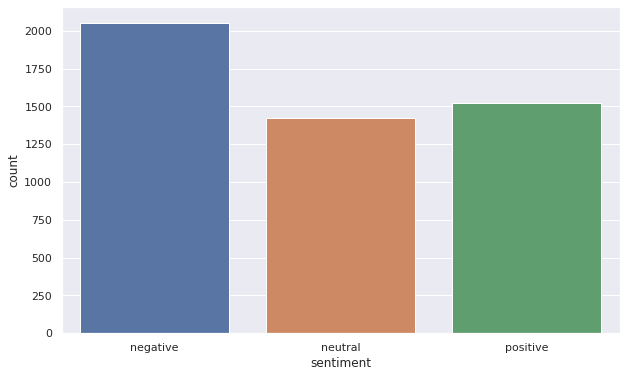

In [ ]:
sns.countplot(x=df["sentiment"], data=df['sentiment'])
sns.set(rc={'figure.figsize':(20,8.27)})

In [ ]:
#Vectorizing text

vectorizer=CountVectorizer()
X_senti_cm=vectorizer.fit_transform(df['Tweet_Text'])

In [ ]:
y_senti_cm=df['sentiment']
y_senti_cm.shape

(5000,)

In [ ]:
#Splitting training and testing part

X_train,X_test,y_train,y_test=train_test_split(X_senti_cm,y_senti_cm,test_size=0.2)

In [ ]:
#Using Complement Naive Bayes Classifier for sentiment analysis

CNB_classifier_sentiment=ComplementNB()
CNB_classifier_sentiment.fit(X_train,y_train)
y_predict=CNB_classifier_sentiment.predict(X_test)

In [ ]:
cm_sentiment=confusion_matrix(y_test,y_predict)

Text(156.5, 0.5, 'Data')

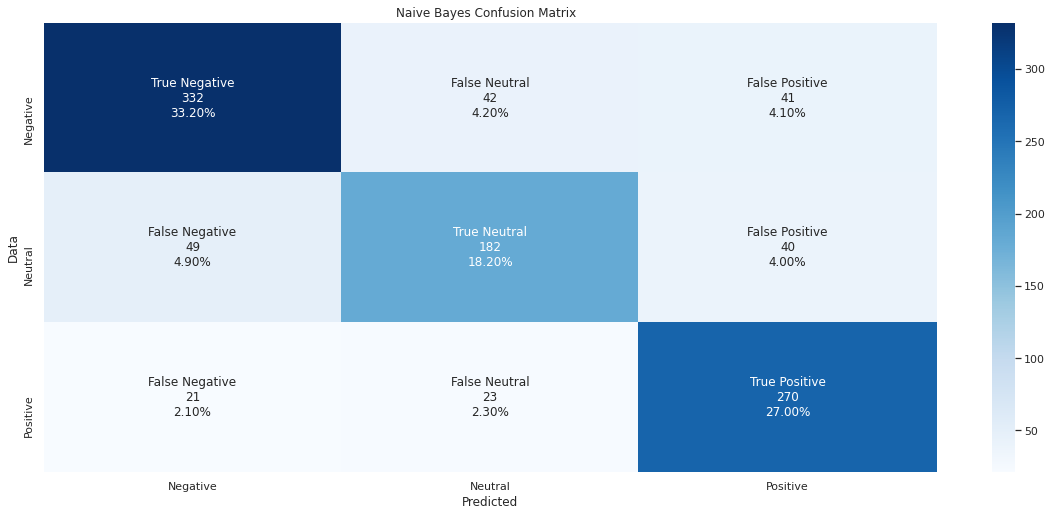

In [ ]:
#Confusion matrix

group_names = ["True Negative","False Neutral","False Positive","False Negative","True Neutral","False Positive","False Negative","False Neutral","True Positive"]

group_counts = ["{0:0.0f}".format(value) for value in
                cm_sentiment.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_sentiment.flatten()/np.sum(cm_sentiment)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
ax= plt.subplot()
ax.set_title('Naive Bayes Confusion Matrix  ');
sns.heatmap(cm_sentiment, annot=labels,ax=ax, fmt='', cmap='Blues')

ax.xaxis.set_ticklabels(['Negative','Neutral', 'Positive']); ax.yaxis.set_ticklabels(['Negative','Neutral', 'Positive']);

plt.xlabel('Predicted')
plt.ylabel('Data')

In [ ]:
#Classification report for sentiment analysis

target_names=['Negative','Neutral' ,'Positive']
Classification_report = classification_report(y_test,y_predict, target_names=target_names)

print(Classification_report)

              precision    recall  f1-score   support

    Negative       0.83      0.80      0.81       415
     Neutral       0.74      0.67      0.70       271
    Positive       0.77      0.86      0.81       314

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



In [ ]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
accuracy_sentiment_naive=metrics.accuracy_score(y_test, y_predict)*100
accuracy_sentiment_naive

78.4

In [ ]:
#Vectorizing text

vectorizer=CountVectorizer()
X_senti_rand=vectorizer.fit_transform(df['Tweet_Text'])
y_senti_rand=df['sentiment']
X_train,X_test,y_train,y_test=train_test_split(X_senti_rand,y_senti_rand,test_size=0.2)

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train,y_train)
y_predict=clf.predict(X_test)
rand_sentiment=confusion_matrix(y_test,y_predict)

#Classification report for sentiment analysis
target_names=['Negative','Neutral' ,'Positive']
Classification_report = classification_report(y_test,y_predict, target_names=target_names)
print(Classification_report)

              precision    recall  f1-score   support

    Negative       0.41      1.00      0.58       402
     Neutral       0.00      0.00      0.00       306
    Positive       1.00      0.03      0.06       292

    accuracy                           0.41      1000
   macro avg       0.47      0.34      0.21      1000
weighted avg       0.46      0.41      0.25      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
accuracy_sentiment_random=metrics.accuracy_score(y_test, y_predict)*100
accuracy_sentiment_random

41.099999999999994

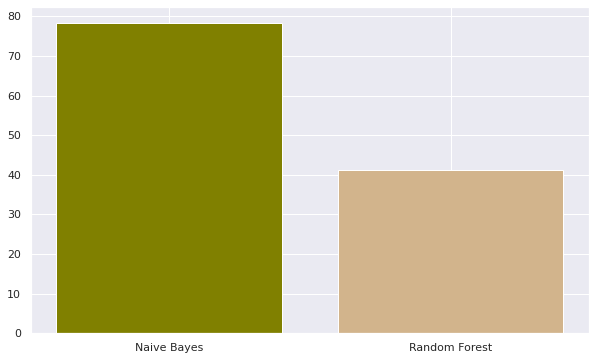

In [ ]:
Accuracy = ['Naive Bayes','Random Forest']
Percent = [accuracy_sentiment_naive,accuracy_sentiment_random]
plt.bar(Accuracy,Percent,color=['olive', 'tan'])
plt.show()

## **Emotion Analysis**

In [ ]:
total=df.emotions.shape[0]
surprise=df[df.emotions == 'Surprise'].shape[0]
print("Surprise   ",surprise*100/total)
happy=df[df.emotions == 'Happy'].shape[0]
print("Happy      ",happy*100/total)
fear=df[df.emotions == 'Fear'].shape[0]
print("Fear       ",fear*100/total)
sad=df[df.emotions == 'Sad'].shape[0]
print("Sad        ",sad*100/total)
angry=df[df.emotions == 'Angry'].shape[0]
print("Angry      ",angry*100/total)

if max(surprise,happy,fear,sad,angry)==surprise:
  rec_word='Surprise'
  print("\033[1mSurprise is maximum")
elif max(surprise,happy,fear,sad,angry)==happy:
  rec_word='Happy'
  print("\033[1mHappy is maximum")
elif max(surprise,happy,fear,sad,angry)==fear:
  rec_word='Fear'
  print("\033[1mFear is maximum")
elif max(surprise,happy,fear,sad,angry)==sad:
  rec_word='Sad'
  print("\033[1mSad is maximum")
else:
  rec_word='Angry'
  print("\033[1mAngry is maximum")

Surprise    25.6
Happy       26.46
Fear        28.64
Sad         14.32
Angry       4.98
Fear is maximum


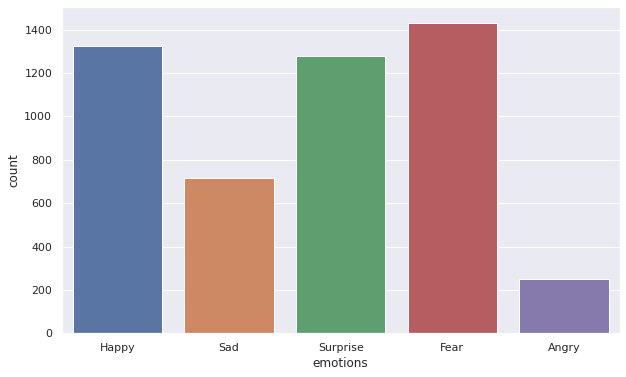

In [ ]:
sns.countplot(x=df["emotions"], data=df['emotions'])
sns.set(rc={'figure.figsize':(10,6)})

In [ ]:
vectorizer=CountVectorizer()
X_emo_cm=vectorizer.fit_transform(df['Tweet_Text']).toarray()

In [ ]:
y_emo_cm=df['emotions']
y_emo_cm.shape

(5000,)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_emo_cm,y_emo_cm,test_size=0.2)

In [ ]:
CB_classifier_emotion=ComplementNB()
CB_classifier_emotion.fit(X_train,y_train)
y_predict=CB_classifier_emotion.predict(X_test)

In [ ]:
cm_emotion=confusion_matrix(y_test,y_predict)

Text(201.5, 0.5, 'Data')

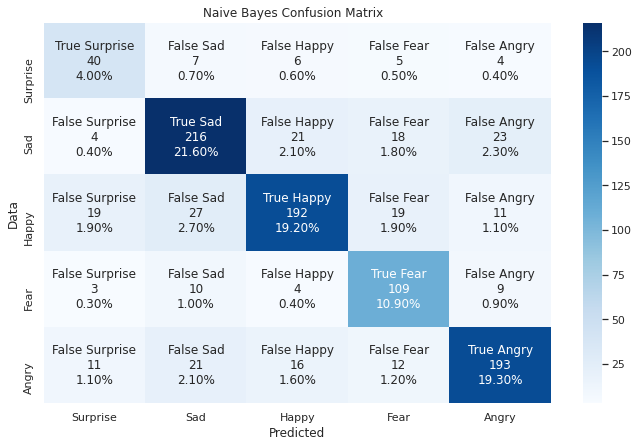

In [ ]:
#Confusion matrix
group_names = ["True Surprise","False Sad","False Happy","False Fear","False Angry","False Surprise","True Sad","False Happy","False Fear","False Angry","False Surprise","False Sad", "True Happy","False Fear","False Angry","False Surprise","False Sad", "False Happy","True Fear","False Angry","False Surprise","False Sad", "False Happy","False Fear","True Angry"]

group_counts = ["{0:0.0f}".format(value) for value in
                cm_emotion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_emotion.flatten()/np.sum(cm_emotion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
f = plt.figure(figsize=(25,7))
ax = f.add_subplot(121)
ax.set_title('Naive Bayes Confusion Matrix  ');
sns.heatmap(cm_emotion, annot=labels,ax=ax, fmt='', cmap='Blues')

ax.xaxis.set_ticklabels(['Surprise','Sad', 'Happy','Fear','Angry']); ax.yaxis.set_ticklabels(['Surprise','Sad', 'Happy','Fear','Angry']);

plt.xlabel('Predicted')
plt.ylabel('Data')

In [ ]:
target_names=['Happy','Sad' ,'Surprise','Fear','Angry']
Classification_report = classification_report(y_test,y_predict, target_names=target_names)

print(Classification_report)
accuracy_emotion_compliment=metrics.accuracy_score(y_test, y_predict)*100

              precision    recall  f1-score   support

       Happy       0.52      0.65      0.58        62
         Sad       0.77      0.77      0.77       282
    Surprise       0.80      0.72      0.76       268
        Fear       0.67      0.81      0.73       135
       Angry       0.80      0.76      0.78       253

    accuracy                           0.75      1000
   macro avg       0.71      0.74      0.72      1000
weighted avg       0.76      0.75      0.75      1000



In [ ]:
accuracy_emotion_compliment

75.0

In [ ]:
vectorizer=CountVectorizer()
X_emo_rand=vectorizer.fit_transform(df['Tweet_Text']).toarray()
y_emo_rand=df['emotions']
y_emo_rand.shape

(5000,)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_emo_rand,y_emo_rand,test_size=0.2)

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train,y_train)
y_predict=clf.predict(X_test)
rand_emotion=confusion_matrix(y_test,y_predict)

#Classification report for sentiment analysis
target_names=['Happy','Sad' ,'Surprise','Fear','Angry']
Classification_report = classification_report(y_test,y_predict, target_names=target_names)

print(Classification_report)
accuracy_emotion_random=metrics.accuracy_score(y_test, y_predict)*100

              precision    recall  f1-score   support

       Happy       0.00      0.00      0.00        39
         Sad       0.33      0.99      0.50       298
    Surprise       0.80      0.13      0.22       251
        Fear       0.00      0.00      0.00       148
       Angry       0.93      0.23      0.37       264

    accuracy                           0.39      1000
   macro avg       0.41      0.27      0.22      1000
weighted avg       0.54      0.39      0.30      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


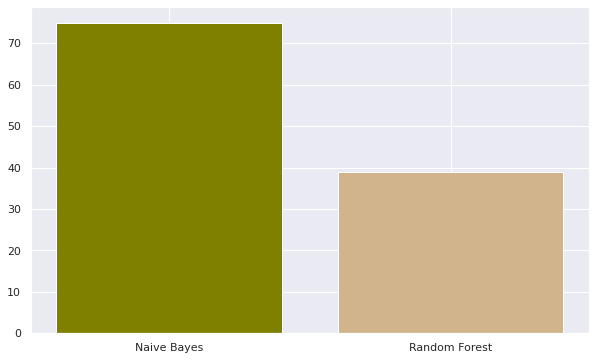

In [ ]:
Accuracy = ['Naive Bayes','Random Forest']
Percent = [accuracy_emotion_compliment,accuracy_emotion_random]
plt.bar(Accuracy,Percent,color=['olive', 'tan'])
# Displaying the bar plot
plt.show()

## **Recommendation of Tweets**

In [ ]:
df2['recommendation'] = np.where(df.emotions == rec_word, df2['Tweet_Text'],None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
for i in range(10):
  x=df2['recommendation'].dropna().sample(1)
  print(x)
  print("\n")


2838    Self isolating for 6 days because one of our managers has tested positive for COVID! 😞
Name: recommendation, dtype: object


4026    COVID-19 in Indiana: 2,494 new coronavirus cases, 43 additional deaths announced in Indiana\nhttps://t.co/xHf4iWcuJH
Name: recommendation, dtype: object


4647    'It's been a really long journey': Firefighter discusses struggles as COVID-19 'long-hauler' https://t.co/qROoMM34hM
Name: recommendation, dtype: object


2317    Manchester City and Everton has been postponed due to COVID-19 cases in the City camp | ⚽️ \n\nhttps://t.co/tlDAZu16HF
Name: recommendation, dtype: object


1536    The outdoors in 2020 – a look back: COVID-19 pandemic drove people outdoors in record numbers https://t.co/YgJlcEDUC7
Name: recommendation, dtype: object


505    RT @latimes: Interviews with 31 epidemiologists, health experts and public officials offer clues: L.A. was far more vulnerable to an extrem…
Name: recommendation, dtype: object


3714    @Newsweek Emails o